# Solving Dynamical Systems using Reservoir Computing

In [1]:
from QRC.solvers import *
from QRC.systems import *
from QRC.post_process import *
from QRC.crc import *
from QRC.qrc import *
from QRC.validation import *
from QRC.CLVs import *
from QRC.CLVs_qrc import *
from QRC.color_map import *
# from QRC.lyapunov import *
#from QRC.lyapunov_gm import *
#numpy
import numpy as np
#plotting libraries
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
#scipy libraries
import sklearn
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor as GPR
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
import scipy.stats as stats 
#time libraries
import h5py
import time
from datetime import date
from timeit import default_timer as timer
today = date.today()

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rcParams['text.usetex']

#TODO
# Add config file so that to run on HPC


True

# Select Systems and Parameters

In [2]:
#for Lorenz 63:
if __name__ == "__main__":
    dt = 0.01
    tot_steps = 100000
    upsample = 1
    q0 =  np.array([7.432487609628195, 10.02071718705213, 29.62297428638419])
    u0 = q0
    #q0 =  np.array([0, 1, 1])
    N_transient = 2000


save_fold = 'VPT_L63'
system = Systems(dt,tot_steps,q0,upsample,N_transient)

dim,N_lyap,N_t = system.set_param_lorenz63() # FOR MFE, N_t should be input so in set_param_MFE -- make it as input
q = system.gen_data_lorenz63()


# for MFE:
# if __name__ == "__main__":
#     dt = 0.25
#     tot_steps = 20000
#     upsample = 1
#     q0   = np.array([1, 0.07066, -0.07066, 0, 0, 0, 0, 0, 0]) 
#     u0   = q0
#     N_t = 2000
#     N_transient = 1000

# save_fold= 'MFE'
# system = Systems(dt,tot_steps,q0,upsample,N_transient)
# sys = 'MFE'
# dim,N_lyap = system.set_param_MFE(N_t) 

# run = False
# save= False
# load = True

# if run:
#     q = system.gen_data_MFE()

# if save:
#     fln = './data/MFE'+'MFE'+'_dt='+str(dt)+'_Nt='+str(N_t)+'_dim='+str(dim)+'_date='+str() # Enter Date
#     hf = h5py.File(fln,'w')
#     hf.create_dataset('q',data=q)
#     hf.close()

# if load:
#     hf      = h5py.File('./data/MFE/'+'MFE'+'_dt='+str(dt)+'_Nt='+str(N_t)+'_dim='+str(dim)+'_date='+str('2023-07-31'))
#     q       = np.array(hf.get('q'))
#     hf.close()


# Pre-process input data 

In [3]:
data_inputs = True
noise       = False # to add noise in flattened time series 
scaling     = True # to scale flattened time series 

if data_inputs:
    N_ts        = 1 # 1 for L63 and L96, 20 for MFE
    N_test_stat = 500 # Time series for testing after N_ts

    N_washout  = 2*N_lyap #10 before for L96 10 D , 2 before for L63 / MFE  
    N_val      = 2*N_lyap # 3 for L63 , # 5 for L96 , 2*N_lyap for MFE
    N_train    = 20*N_lyap #200 before for L96 10D , 20 before for L63 / MFE  
    N_test     = 200*N_lyap
 


# All above in this block are Inputs
q_unscaled = q
UU = q # backup of complete time series
print('Laminarized precentage', np.round(100-((q.shape[0])*100/N_t),2),'(relevant for MFE)')

q = q[:N_ts+N_test_stat,:,:] # trimmed time series

print('Retaining ',N_ts, 'series for training and validation')
print('Additional ',N_test_stat, 'series for testing and statistical predictions')

# Rescaling Input Time Series after flattening it (only retained series)
q0 = q.shape[0] # Total time series, Train+Val+Test
q1 = q.shape[1] # Length of each time series
q_U = q.reshape(q0*q1, dim)

if scaling:
    q = sklearn.preprocessing.minmax_scale(q_U, feature_range=(0, 1), axis=0, copy=True) # rescaling flattened array
    q  = q.reshape(q0,q1,dim) # making 3 dimensional again

# from here q has scaled data
q_tv = q[:N_ts,:,:]  # From q retaining training set (N_ts)
q_test = q[N_ts:N_ts+N_test_stat,:,:]  #From q removing retaining test set(N_test_stat)

# Training, Validation Parameters
UU = q_tv # Training, validation set
N0 = UU.shape[0] # Retained Time series for training
N1 = UU.shape[1] # Length of each time series
print('UU Size =',UU.shape) # 3 dim
U = UU.reshape(N0*N1, dim) # Generating flattened time series for addition of noise and normalization
print('U Size =',U.shape) # 2 dim 

if noise: # adding noise in training set
    target_snr_db=40
    seed=0
    UU = add_noise(U,target_snr_db,seed,dim,N0,N1)

#compute norm
U_data = U[:N_washout+N_train+N_val]
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m
u_mean = U_data.mean(axis=0)

# washout
U_washout = UU[:,:N_washout]
# training + validation
U_tv  = UU[:,N_washout:N_washout+N_train+N_val-1]
Y_tv  = UU[:,N_washout+1:N_washout+N_train+N_val]
# Testing
U_test  = UU[:,N_washout+N_train+N_val:N_washout+N_train+N_val+N_test-1]
Y_test  = UU[:,N_washout+N_train+N_val+1:N_washout+N_train+N_val+N_test]

print('N_lyap:', N_lyap)
print('N_train =',int(N_train/N_lyap),'N_lyap',' x ',str(N_ts),'series')
print('N =',int((N_washout+N_val+N_train)/N_lyap),'N_lyap',', Total steps of training=',int(N_washout+N_val+N_train),', Out of = ',N0*N1)
print('The shape of q_tv is '+str(q_tv.shape)+ ' to train on ' +str(N_ts)+  ' time series')
print('The shape of q_test is '+str(q_test.shape)+ ' to test ' +str(N_test_stat)+  ' time series, and for stats predictions (relevant for MFE)')
print('The shape of q is '+str(q.shape)+ ' combining above')
print('The shape of U_test is '+str(U_test.shape)+ ' combining above')


Laminarized precentage 0.0 (relevant for MFE)
Retaining  1 series for training and validation
Additional  500 series for testing and statistical predictions
UU Size = (1, 98000, 3)
U Size = (98000, 3)
N_lyap: 111
N_train = 20 N_lyap  x  1 series
N = 24 N_lyap , Total steps of training= 2664 , Out of =  98000
The shape of q_tv is (1, 98000, 3) to train on 1 time series
The shape of q_test is (0, 98000, 3) to test 500 time series, and for stats predictions (relevant for MFE)
The shape of q is (1, 98000, 3) combining above
The shape of U_test is (1, 22199, 3) combining above


# Visualize input data

In [4]:
# l1 = 8000
# l2 = 5000
# l3 = 5000

# plot_lorenz63_attractor(U,l1)
# plot_lorenz63_time(U,N_lyap,l2,l3)
# plt.show()

# Stability properties - Ground Truth

# Lyapunov exponents

Dynamical system: VPT_L63
Target Lyapunov exponents:  [ 8.96432288e-01  4.82435681e-04 -1.45634799e+01]


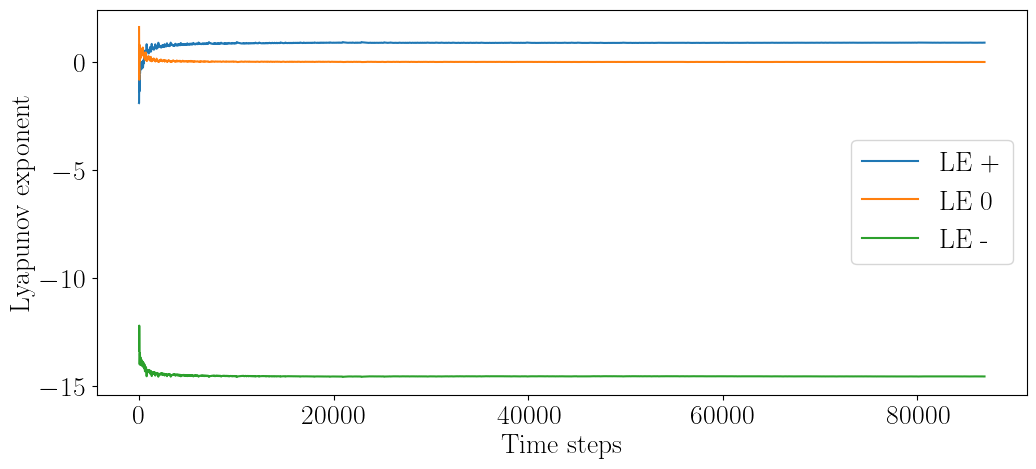

In [5]:
Ntotal = 1000*N_lyap #*5 # for CLVs angles and PDFs conversion ~ 50000 steps required
Ntherm = int(Ntotal /10)

if save_fold == 'VPT_L63':
    sys = 'lorenz63'
    # params = [8/3, 28, 10]

if save_fold == 'MFE':
    sys = 'MFE'
    params = []
    
ensemble  = 1
norm_time = 1
LEs_ens  = []
FTLE_ens = []
RR_t_ens = []
QQ_t_ens = []
Yt_ens   = []

eom = system.solve_lorenz63
jac = system.solve_lorenz63_jac
sys_type = "continuous"


# X = UU[0][Ntotal:]
X = q_unscaled[0][:Ntotal]

physical_time = np.arange(0, X.shape[0] * dt, dt)

LEs, FTLE, QQ, RR = calculate_LEs(save_fold,system,sys_type,X,physical_time,Ntherm,dt,norm_time,target_dim=3)

V, theta, ftcle = calculate_CLVs(QQ,RR,dt)
thetas = CLV_angles_true(V,target_dim=3)

LEs_targ = LEs[-1]

print('Target Lyapunov exponents: ',LEs_targ)

plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["font.size"] = 20

if save_fold == 'VPT_L63':
    plt.plot(LEs[:,0], label='LE +')
    plt.plot(LEs[:,1], label='LE 0')
    plt.plot(LEs[:,2], label='LE -')
    

plt.xlabel("Time steps")
plt.ylabel("Lyapunov exponent")
plt.legend()
plt.show()



# KY Dimension

Kaplan Yorke dimension Ground Truth:  [2.0616]


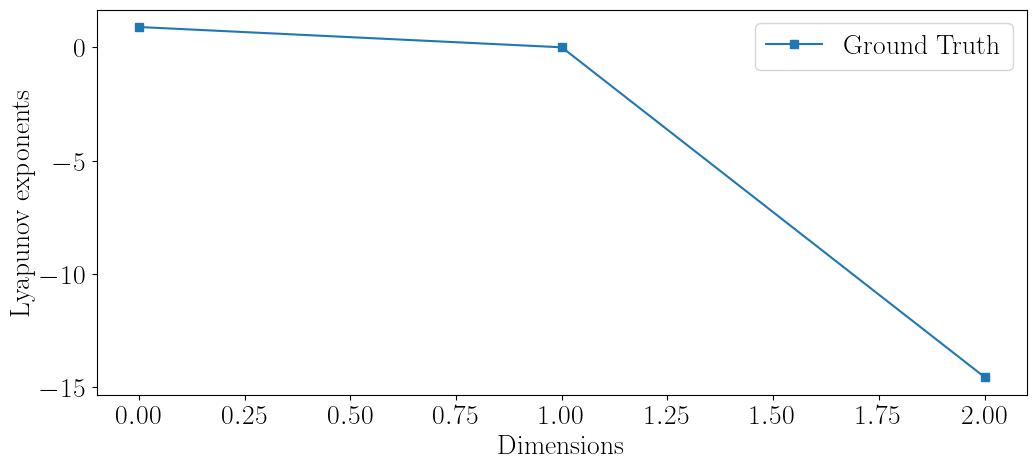

In [6]:
cmap = plt.get_cmap('BuPu_r')
colors = [cmap(i) for i in np.linspace(0, 0.5, ensemble)]
LEs_true = []
for i in range(ensemble):
    LEs_plot = LEs[-1]
    plt.plot(LEs_plot,marker='s',label='Ground Truth')
    LEs_true += [LEs_plot]
plt.xlabel("Dimensions")
plt.ylabel("Lyapunov exponents")
plt.legend()

KY_true = []
for i in range(ensemble):
    KY_true += [ky_dimension(LEs_true[i])]

print('Kaplan Yorke dimension Ground Truth: ', np.round(KY_true,4))

plt.show()    



# CLVs

Ground truth


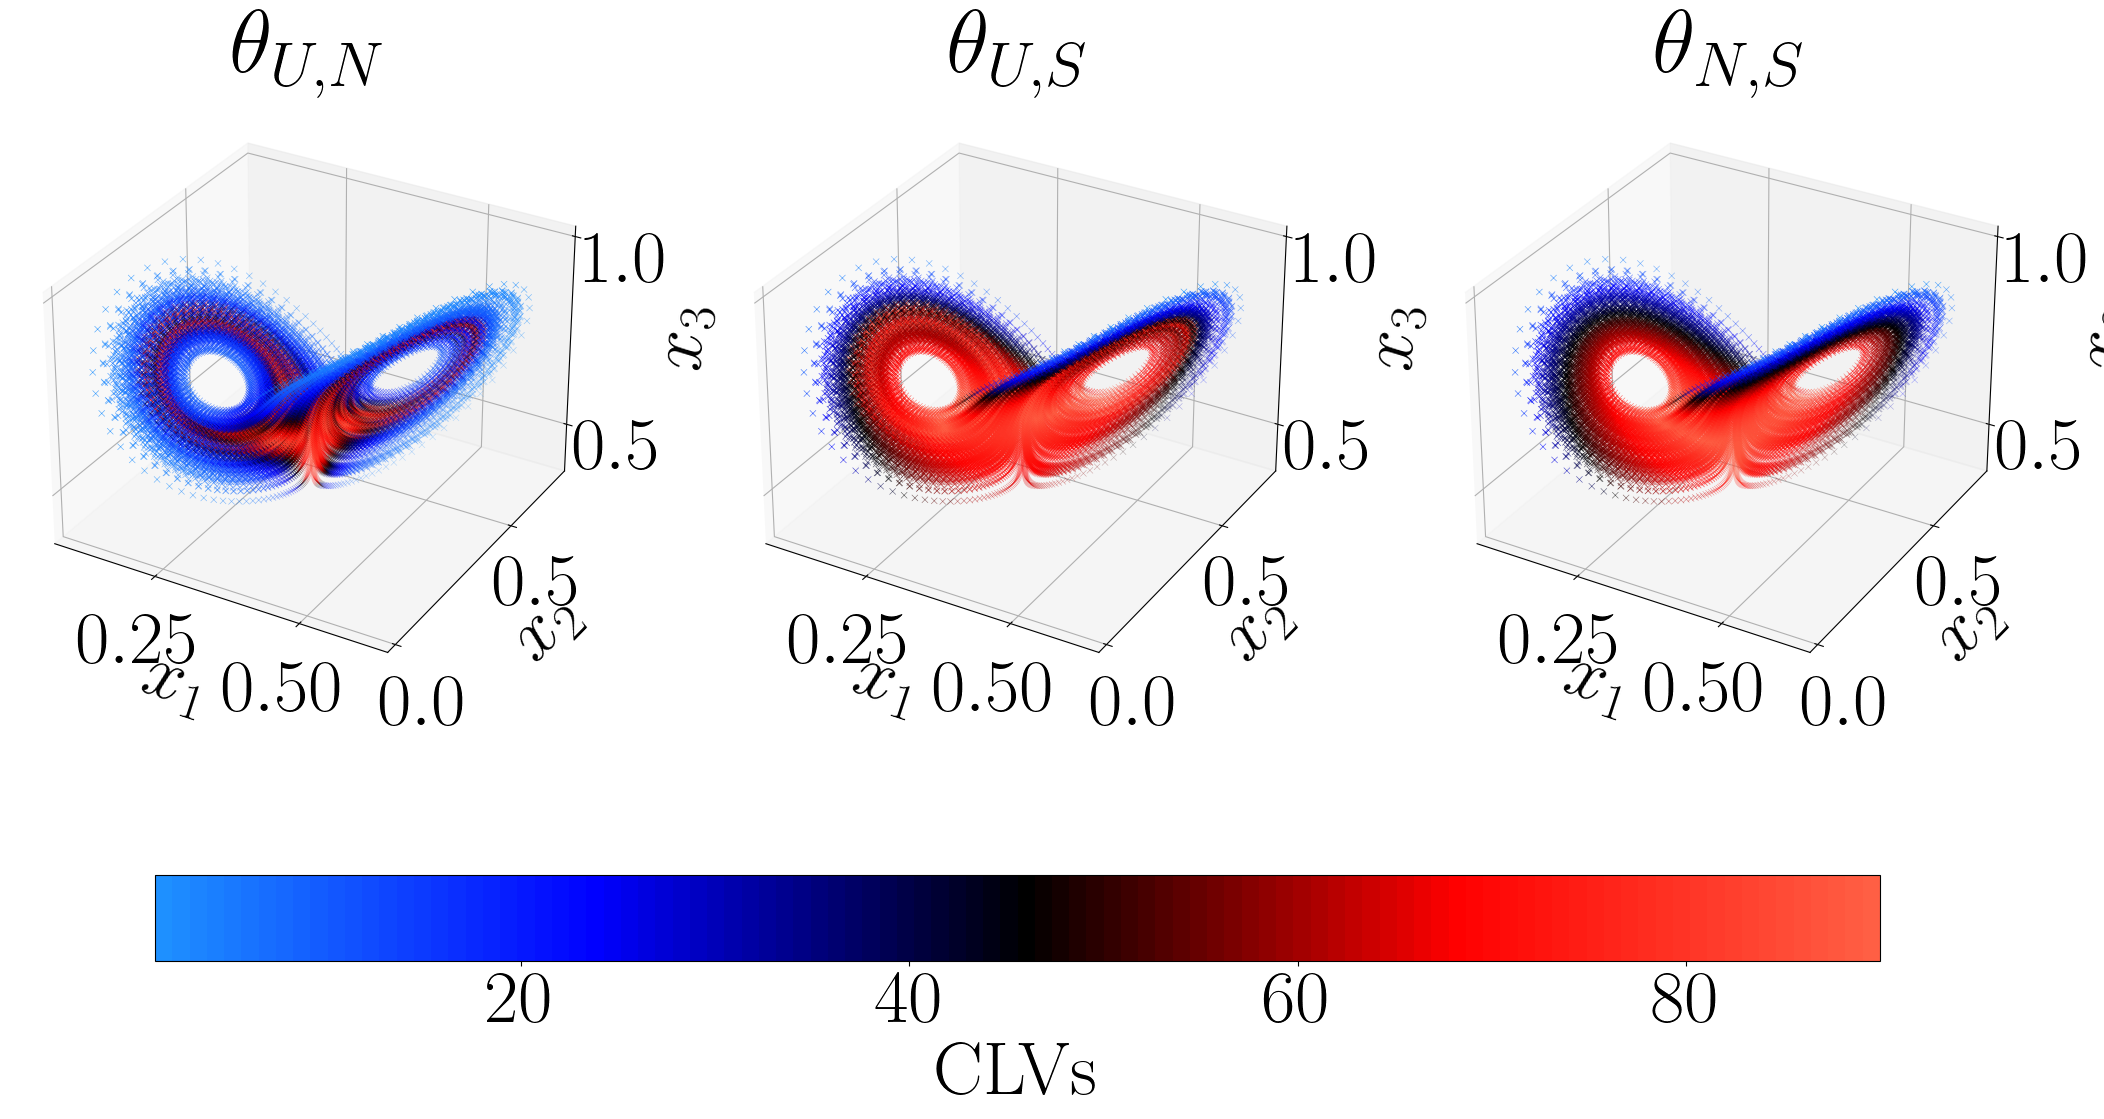

In [7]:
plt.rcParams["font.size"] = 54
plt.rcParams["figure.figsize"] = (22,6)


length_plot = 20000
transients = 1000

custom_continuous_cmap = create_custom_colormap(map_name='name',type='continuous',N=100,colors=["dodgerblue","blue","black","red","tomato"])
color_plot = custom_continuous_cmap  #"jet"# #custom_continuous_cmap #'coolwarm'# # own_color

scaling_domain = True
# QRC / RF-QRC is scaled between 0-1 (Table 2) rescaling true data for comparison

if scaling_domain:
    Xs = sklearn.preprocessing.minmax_scale(X.flatten(), feature_range=(0, 1), axis=0, copy=True) # rescaling flattened array
    Xs = Xs.reshape(X.shape[0],X.shape[1]) # making 3 dimensional again

print('Ground truth')
plot_lorenz63_attractor_clvs_subplot(Xs[Ntherm:],length_plot,thetas[:length_plot],color_plot)


# CLVs PDFs

0.7417844211711719 90.0
9.13806493709527 90.0
8.971423090284079 90.0


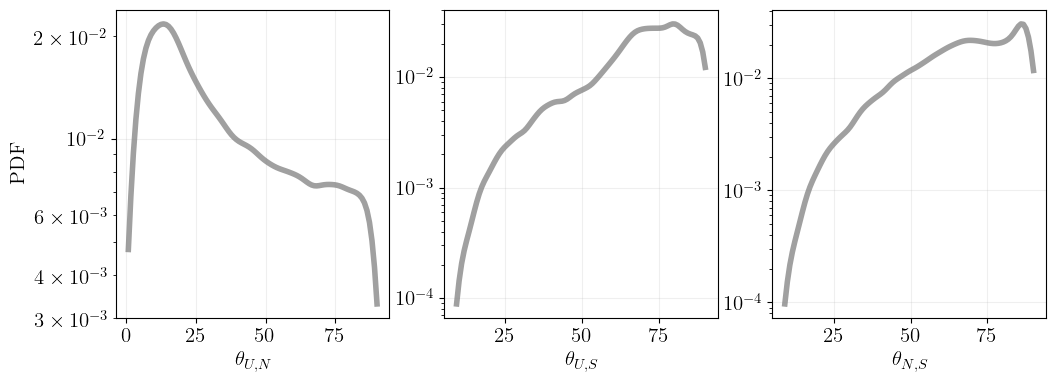

In [8]:
dist    = 100
kde_true = plot_lorenz63_CLV_stats(thetas[transients:],dist)


# Quantum Reservoir Computing - Initialization

In [9]:
# Defining Qbit and Cbits
n              = 7 # 9 Qubits and classical
Nres           = 2**n # Total Reservoir Size
qubits         = n

# Required Input Parameters
N_units_q      = Nres #neurons or N_res in paper
bias_in        = np.array([np.mean(np.abs((U_data-u_mean)/norm))])  # Input bias, b_in to break the inherent symmetry of ESN Structure
bias_out       = np.array([1]) #output bias 

# Hyperparameters
tikh_q        = np.array([1e-12])  # Tikhonov Param (Beta),  adds a regularization or weight decay term that penalizes large Wout values 
sigma_in_q    = 1
rho_q         = 1.0 # [Spectral Radius]
epsilon_q     = 0.05 # Leaking Rate

# Ensembles for QRC
qu_ensemble   = 5

# Training 

In [10]:
Configurations = ['Linear+Full+FullSymmetric','Linear+Linear+Linear','None+Linear+Linear','None+Full+FullSymmetric','None+Products+Linear','None+Products+FullSymmetric','None+Linear+FullSymmetric','None+Linear_New+FullySymmetric','None+Linear_New+Linear_New']
config_list    = ['config1','config2','config3','config4','config5','config6','config7','config8','config9']
qc_type        = config_list[3]
config         = 4 # for initializing class its +1 of the list above

emulator_list  = ['sv_sim','qasm_sim']
emulator       = emulator_list[0]

method_list    = ['sv','shots1k','shots5k','shots10k','shots20k','shots30k','shots40k','shots50k','shots75k','shots100k','shots200k','shots1']
shot_list      = [None,1000,5000,10000,20000,30000,40000,50000,75000,100000,200000,400000,1]

## SHOT INPUT
shot_index     = 0

method = method_list[shot_index]
total_shots  = shot_list[shot_index]


shots = total_shots

snapshots = 1
print('Configuration:',qc_type,'Emulator:',emulator,'Total shots:',total_shots,'Individual Shots:',shots)

# Initialize Class
QESN   = QuantumReservoirNetwork(rho_q,epsilon_q,sigma_in_q,tikh_q,bias_in,bias_out,qubits,N_units_q,dim,config,emulator,shots,snapshots)

# Parameterized or not
QESN.method_qc(parameterized=False)

# Generate parameterized quantum circuit for a given configuration
# QESN.gen_param_quantumcircuit()

quantum_training = True
run_training     = True
save_training    = False
load_training    = False

Xa_qq    = []
Woutt_qq    = np.zeros(((qu_ensemble, QESN.N_units+1,dim)))
LHS_qq   = []
RHS_qq   = []
alpha_qc = []

eps_fix  = 0.05
tikh_q   = np.array([1e-12])
eps_q_list = np.linspace(0.05,0.98,qu_ensemble)
# eps_q_list = np.ones(len(eps_q_list))*eps_fix
alpha_range    = 4*np.pi

start = timer()

if quantum_training:
    for i in range(qu_ensemble):
        
        print('Network',i+1,' out of ',qu_ensemble)
        seed           = i
        
        # Quantum Variational Part
        QESN.epsilon_q = eps_q_list[i]

        alpha_q          = QESN.gen_random_unitary(i,alpha_range)
        alpha_qc        += [alpha_q]


        if load_training:
            print('Loading existing Wout matrix')
            #hf       = h5py.File('./data/MFE/Woutt_qq='+str(dt)+'-Nres'+str(N_units_q)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'script')#+'-noise')
            #hf        = h5py.File('./data/MFE/Woutt_qq='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(qu_ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
            hf       = h5py.File('./data/VPT_L63/Woutt_qq='+str(dt)+'-Nres'+str(N_units_q)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
            #hf      = h5py.File('./data/{}_New/Woutt_qq='.format(save_fold)+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(qu_ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
            #hf      = h5py.File('./data/{}/Woutt_qq='.format(save_fold)+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(qu_ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
            
            Woutt_qq       = np.array(hf.get('Woutt_qq'))
            hf.close()
        

        if run_training:
            print('Training...')
            Xa_qc, Woutt_qc, LHS_qc, RHS_qc = QESN.quantum_training(U_washout, U_tv, Y_tv, alpha_qc[i])
                    
            Xa_qq       += [Xa_qc]
            Woutt_qq[i]  = Woutt_qc # saving Output matrix as array 
            LHS_qq      += [LHS_qc]
            RHS_qq      += [RHS_qc]
                
alpha_qq = alpha_qc
# Woutt_qq = Woutt_qq

if load_training:
    Woutt_qq = np.reshape(Woutt_qq,[qu_ensemble, QESN.N_units+1,dim]) # If loading previously saved Woutt , need to reshape 4D to 2D

end = timer()

training_time = (end-start)
print(training_time)


if save_training:
    fln      = ('./data/{}/Woutt_qq='.format(save_fold)+str(dt)+'-Nres'+str(N_units_q)+'-Ensemble'+str(qu_ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
    hf       = h5py.File(fln,'w')
    hf.create_dataset('Woutt_qq',data=Woutt_qq)
    hf.close()


Configuration: config4 Emulator: sv_sim Total shots: None Individual Shots: None
Network 1  out of  5
Training...
Network 2  out of  5
Training...
Network 3  out of  5
Training...
Network 4  out of  5
Training...
Network 5  out of  5
Training...
36.18647701665759


# Predictions 

For time series 0
(98000, 3) (1, 98000, 3) 1
Realization    : 1
Quantum Hyperparameters: 1.0 0.05 1 [1.e-12] Seed: 1
PH quantiles [Lyapunov Times]: [7.62612613 5.25225225 4.75675676]



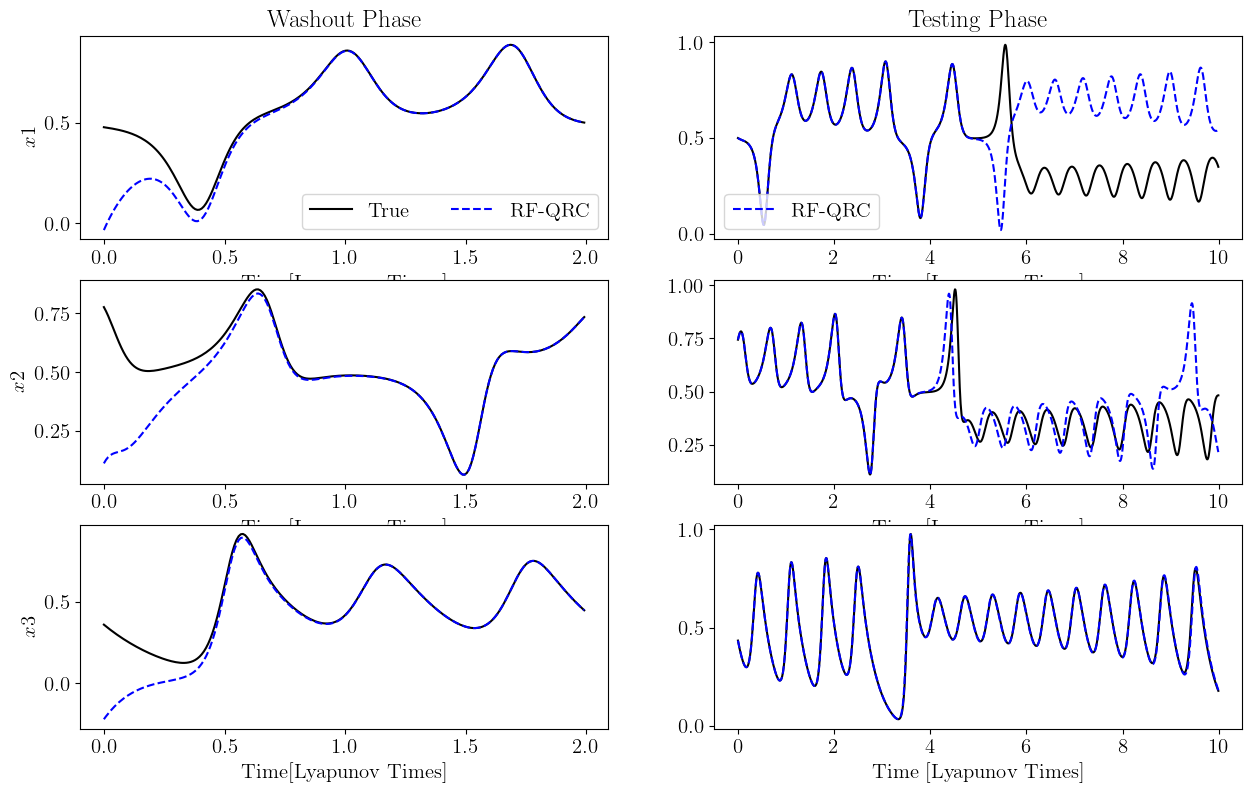

(98000, 3) (1, 98000, 3) 1
Realization    : 2
Quantum Hyperparameters: 1.0 0.2825 1 [1.e-12] Seed: 2
PH quantiles [Lyapunov Times]: [7.6981982  5.3963964  4.86036036]



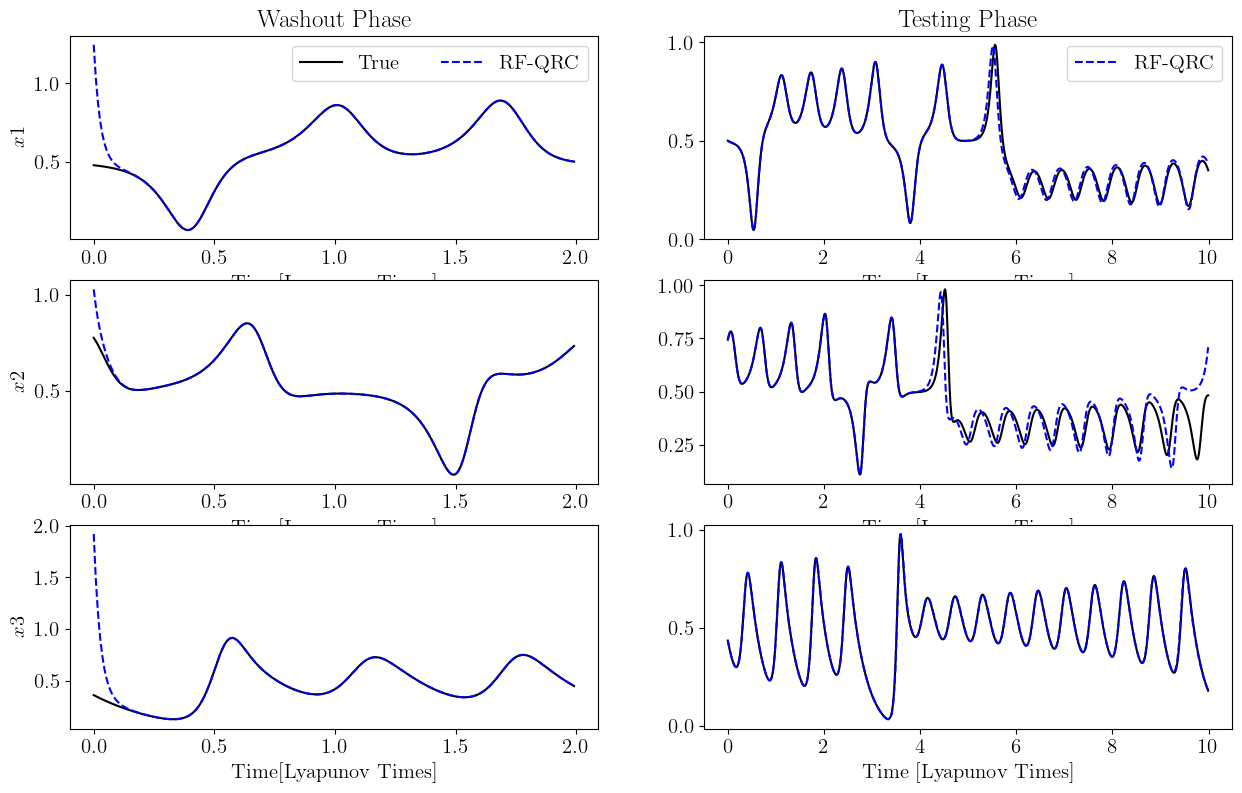

(98000, 3) (1, 98000, 3) 1
Realization    : 3
Quantum Hyperparameters: 1.0 0.515 1 [1.e-12] Seed: 3
PH quantiles [Lyapunov Times]: [4.80630631 4.41441441 3.93693694]



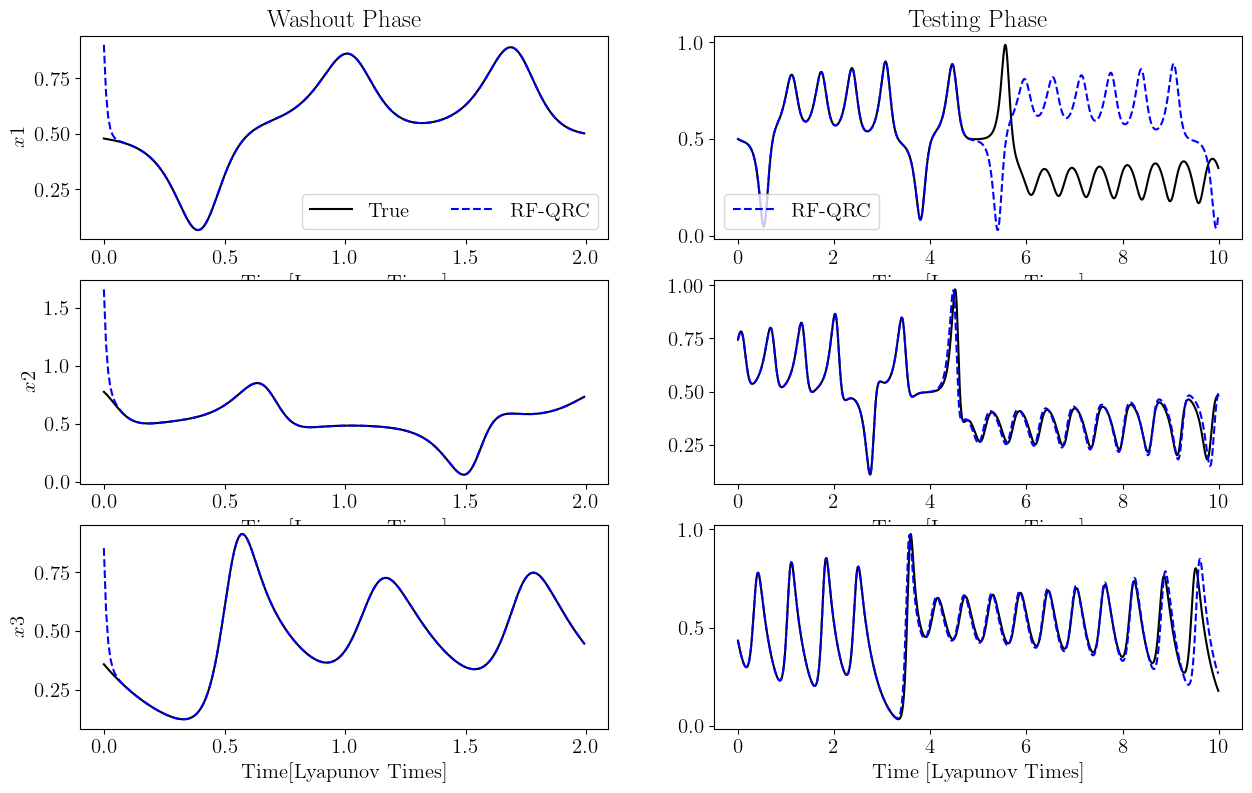

(98000, 3) (1, 98000, 3) 1
Realization    : 4
Quantum Hyperparameters: 1.0 0.7475 1 [1.e-12] Seed: 4
PH quantiles [Lyapunov Times]: [4.68468468 4.12612613 3.73423423]



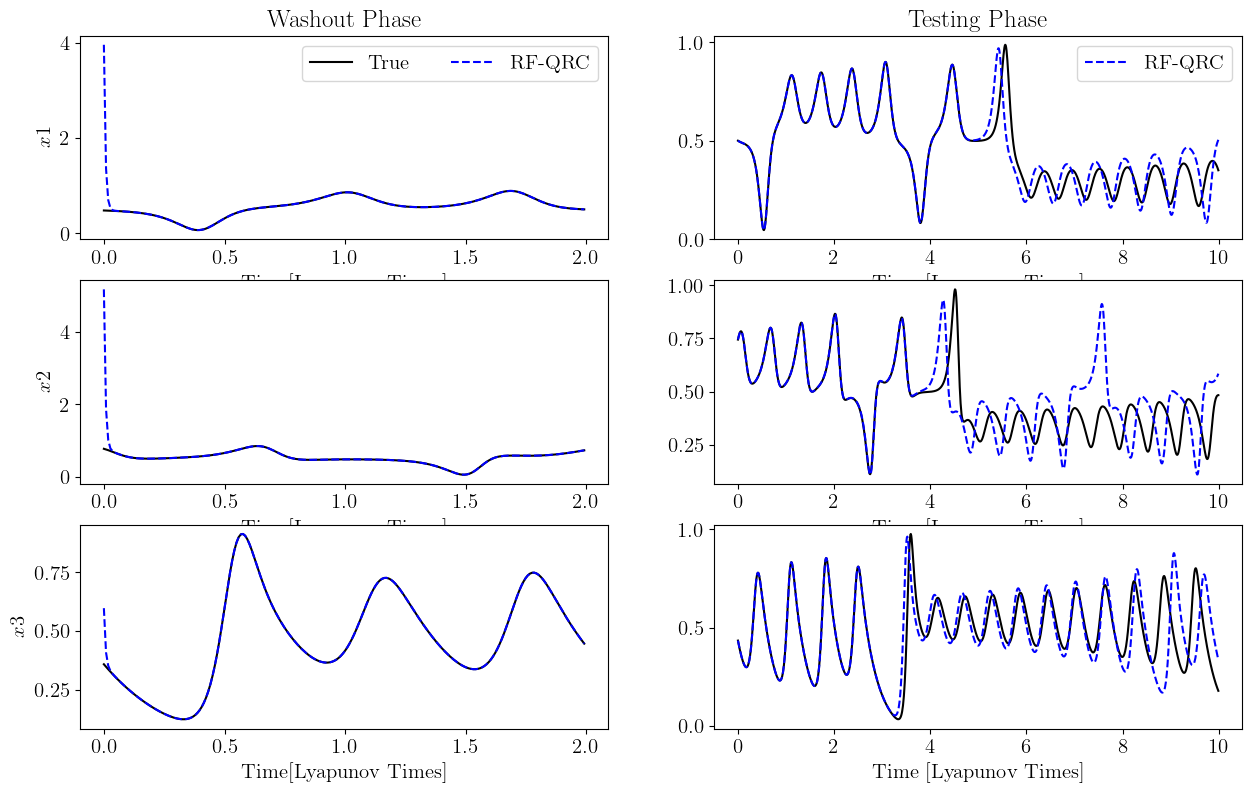

(98000, 3) (1, 98000, 3) 1
Realization    : 5
Quantum Hyperparameters: 1.0 0.98 1 [1.e-12] Seed: 5
PH quantiles [Lyapunov Times]: [4.68018018 4.27027027 3.88738739]



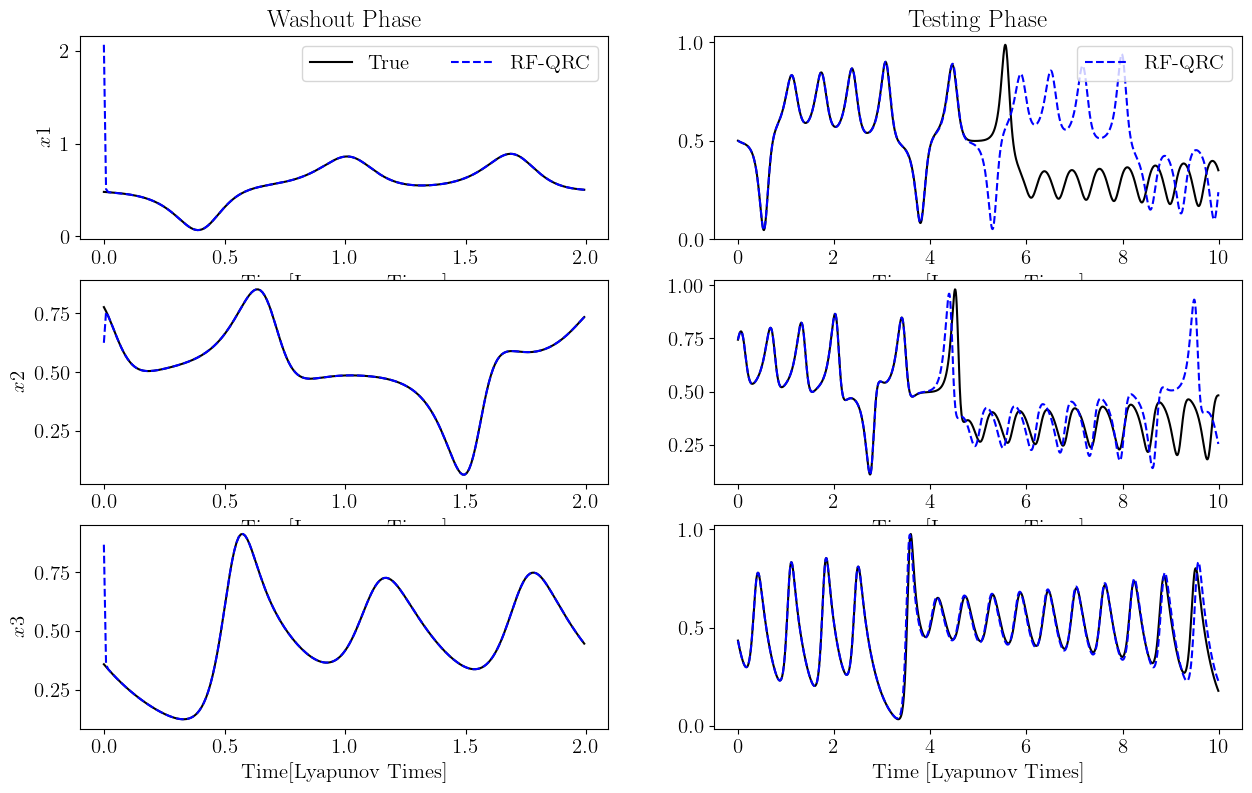

In [12]:
## MODIFY Post processing functionss
quantum_plots = True
N_test   = dim   #number of intervals in the test set
N_tstart = N_washout          # where the first test interval starts
N_intt   = 10*N_lyap          # length of each test set interval
N_fwd    = 1*N_lyap

len_open = N_washout          # Should be < N_washout because of implementation
len_closed = 10*N_lyap

factor = 100*N_lyap           # statistical predictions

Y_tp      =  []
Yh_tp     =  []
Yh_t_qp   =  []
PH_plot_p  =  []
PH_plot_pq =  []
PH_series  = []
PH_series_q  = []

time_series = np.array([0]) # relevant for MFE

            
for j in range(len(time_series)):
    num_series = time_series[j]
    print('For time series',num_series)

    for i in range(qu_ensemble):
        seed  = i+1
        QESN.epsilon_q = eps_q_list[i]
        
        if quantum_plots:
            U_wash,  Y_t , Uh_wash_q, Yh_t_q , PH_plot_q = lorenz63_timeseries_plot_quantum_only(N_test,N_tstart,N_intt,N_fwd,i,UU,U,U_test,N_washout,N_lyap,qu_ensemble,N_t,QESN,Woutt_qq,alpha_qq,plot=True,quantum=True)
            Y_tp       +=  [Y_t]
            Yh_t_qp    +=  [Yh_t_q]
            PH_plot_pq += [PH_plot_q[i]]
                    
    PH_series_q += [PH_plot_pq]


# Conditional Lyapunov exponents (RF-QRC)

In [13]:
step_le = 5000

num_series = time_series[0]

U_wash = U_test[num_series,N_tstart - N_washout +i*N_fwd : N_tstart + i*N_fwd].copy()


for ii in range(qu_ensemble):
    
    alpha = alpha_qq[ii]

    Xa_wash   = QESN.quantum_openloop(U_wash, np.zeros(QESN.N_units),alpha) # here concatenation and bias out addition
    Uh_wash   = np.dot(Xa_wash, Woutt_qq[ii])
    
    QESN.epsilon_q = eps_q_list[ii]
    print('For the ensemble',ii+1)
    print('The leak rate is',QESN.epsilon_q)
    Yh_open, xa_open, CLEs = QESN.quantum_open_loop_jacobian_leakrate(system, step_le, dt, Xa_wash[-1], alpha, Woutt_qq[ii], L=1, norm_time=1)
    



For the ensemble 1
The leak rate is 0.05
Conditional Lyapunov exponents:  [-5.12932944 -5.12932944 -5.12932944]
For the ensemble 2
The leak rate is 0.2825
Conditional Lyapunov exponents:  [-33.19823313 -33.19823313 -33.19823313]
For the ensemble 3
The leak rate is 0.515
Conditional Lyapunov exponents:  [-72.3606388 -72.3606388 -72.3606388]
For the ensemble 4
The leak rate is 0.7475
Conditional Lyapunov exponents:  [-137.63440303 -137.63440303 -137.63440303]
For the ensemble 5
The leak rate is 0.98
Conditional Lyapunov exponents:  [-391.20230054 -391.20230054 -391.20230054]


# Prediction of Lyapunov Spectrum - QRC

In [14]:
step_le = 20000

num_series = time_series[0]

U_wash = U_test[num_series,N_tstart - N_washout +i*N_fwd : N_tstart + i*N_fwd].copy()

Yh_t_qrc  = []
RR_t_qrc  = []
QQ_t_qrc  = []
LEs_t_qrc = []

for ii in range(qu_ensemble):
    
    alpha = alpha_qq[ii]

    Xa_wash   = QESN.quantum_openloop(U_wash, np.zeros(QESN.N_units),alpha) # here concatenation and bias out addition
    Uh_wash   = np.dot(Xa_wash, Woutt_qq[ii])
    
    QESN.epsilon_q = eps_q_list[ii]
    print('For the ensemble',ii+1)
    print('The leak rate is',QESN.epsilon_q)
    QQ_q, RR_q ,Yh_q, xa_q, LEs_q = QESN.quantum_closed_loop_jacobian_leakrate(system,step_le, dt,Xa_wash[-1], alpha, Woutt_qq[ii], norm, norm_time=1,layered=True) # Implementation with leak rate
    Yh_t_qrc  += [Yh_q]
    RR_t_qrc  += [RR_q]
    QQ_t_qrc  += [QQ_q]
    LEs_t_qrc += [LEs_q]


For the ensemble 1
The leak rate is 0.05
RF-QRC Lyapunov exponents:  [ 9.08688133e-01  2.12052462e-03 -5.12929427e+00]
For the ensemble 2
The leak rate is 0.2825
RF-QRC Lyapunov exponents:  [ 8.95014974e-01  5.68765000e-04 -1.45848908e+01]
For the ensemble 3
The leak rate is 0.515
RF-QRC Lyapunov exponents:  [ 9.07512496e-01 -4.18138906e-03 -1.46901126e+01]
For the ensemble 4
The leak rate is 0.7475
RF-QRC Lyapunov exponents:  [ 9.16946062e-01  4.40289516e-03 -1.51986625e+01]
For the ensemble 5
The leak rate is 0.98
RF-QRC Lyapunov exponents:  [ 9.08464978e-01  3.03826955e-03 -1.50388030e+01]


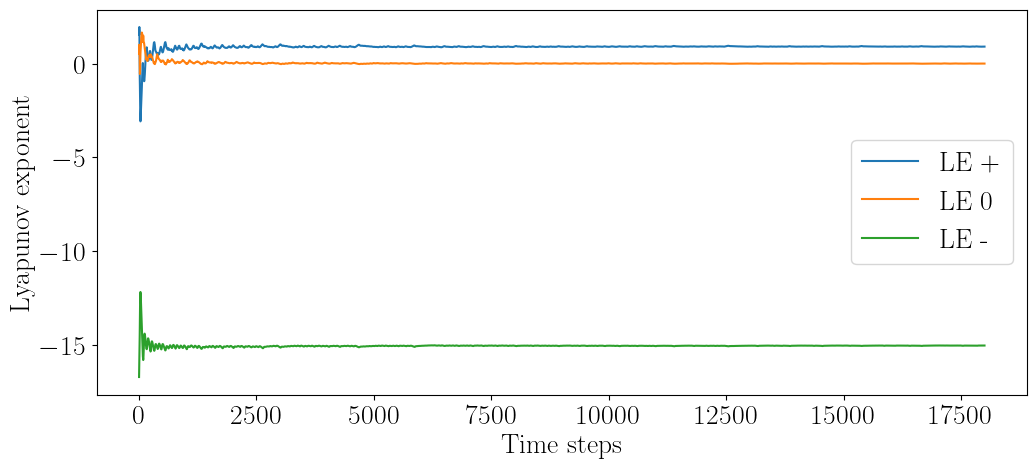

In [15]:
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["font.size"] = 20

if save_fold == 'VPT_L63':
    plt.plot(LEs_q[:,0], label='LE +')
    plt.plot(LEs_q[:,1], label='LE 0')
    plt.plot(LEs_q[:,2], label='LE -')
    
plt.xlabel("Time steps")
plt.ylabel("Lyapunov exponent")
plt.legend()
plt.show()

# Comparison of solutions

Lyapunov exponents and KY dimension

Kaplan Yorke dimension Ground Truth:  [2.0606]
Kaplan Yorke dimension Predicted:  [2.0606]


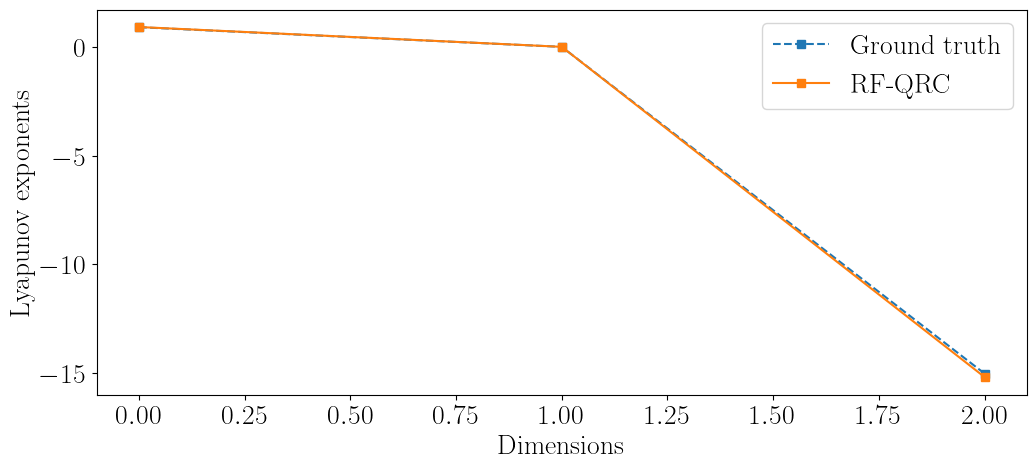

In [36]:
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["font.size"] = 20

cmap = plt.get_cmap('BuPu_r')
colors = [cmap(i) for i in np.linspace(0, 0.5, ensemble)]
LEs_true = []
for i in range(ensemble):
    LEs_plot = LEs[-1]
    plt.plot(LEs_plot,marker='s',linestyle='--',label='Ground truth')
    LEs_true += [LEs_plot]
plt.xlabel("Dimensions")
plt.ylabel("Lyapunov exponents")
plt.legend()

KY_true = []
for i in range(ensemble):
    KY_true += [ky_dimension(LEs_true[i])]


## Quantum
ens = [3] # Select ensemble number to plot and compare
KY_qrc  = []

for j in ens:
    KY_qrc += [ky_dimension(LEs_t_qrc[j][-1])]
    
for j in ens:
    LEs_q_plot = LEs_t_qrc[j][-1]
    plt.plot(LEs_q_plot,marker='s',label='RF-QRC')


print('Kaplan Yorke dimension Ground Truth: ', np.round(KY_true,4))
print('Kaplan Yorke dimension Predicted: ', np.round(KY_true,4))

plt.legend()
plt.show()    



CLVs calculation

In [37]:

if save_fold == 'VPT_L96_{}'.format(dim) :
    if dim==10:
        subspace_LEs_indeces = [3,1]

    elif dim==20:
        subspace_LEs_indeces = [6,1]


if save_fold == 'VPT_L63':
    subspace_LEs_indeces=[]


saveclvs   = 'angles'
fname      = './data/VPT_L63/CLVs='+str(dt)+'-Nres'+str(N_units_q)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)+'-noise'+str(noise)+'N_train'+str(N_train)+'new'
NLy        = dim #?? check
print("Calculate CLVs")    
    
fname = ''
saveclvs = 'angles'


angle_clv_qrc = []
clv_idx   = [(0, 1), (0, 2), (1, 2)]

for k in range(qu_ensemble):
    
    num_series = time_series[0]

    U_wash = U_test[num_series,N_tstart - N_washout +i*N_fwd : N_tstart + i*N_fwd].copy()

    alpha = alpha_qq[k]
    QESN.epsilon_q = eps_q_list[k]
    Xa_wash   = QESN.quantum_openloop(U_wash, np.zeros(QESN.N_units),alpha)
    Uh_wash   = np.dot(Xa_wash, Woutt_qq[k])

    RR_t      = np.array(RR_t_qrc[k])
    QQ_t      = np.array(QQ_t_qrc[k])
    LEs       = np.array(LEs_t_qrc[k])
    
    clvs                     = compute_CLV(QQ_t, RR_t, dt)
    costhetas , thetas_clv   = compute_thetas(clvs,clv_idx=clv_idx)
    # clvs , FTCLE , FTLE , LEs, thetas_clv = CLV_calculation(save_fold,QQ_t,RR_t,dim,Ntherm,dim,dt,fname,U_test[0][-1], norm_time, saveclvs, LEs, FTLE, subspace_LEs_indeces)
    print(thetas_clv[-1])
    angle_clv_qrc += [thetas_clv]




Calculate CLVs
[90. 90. 90.]
[90. 90. 90.]
[90. 90. 90.]
[90. 90. 90.]
[90. 90. 90.]


Statistics - CLV angles

0.7417844211711719 90.0
0.9874363443593912 90.0
9.13806493709527 90.0
13.25521224180869 90.0
8.971423090284079 90.0
13.574902157928912 90.0


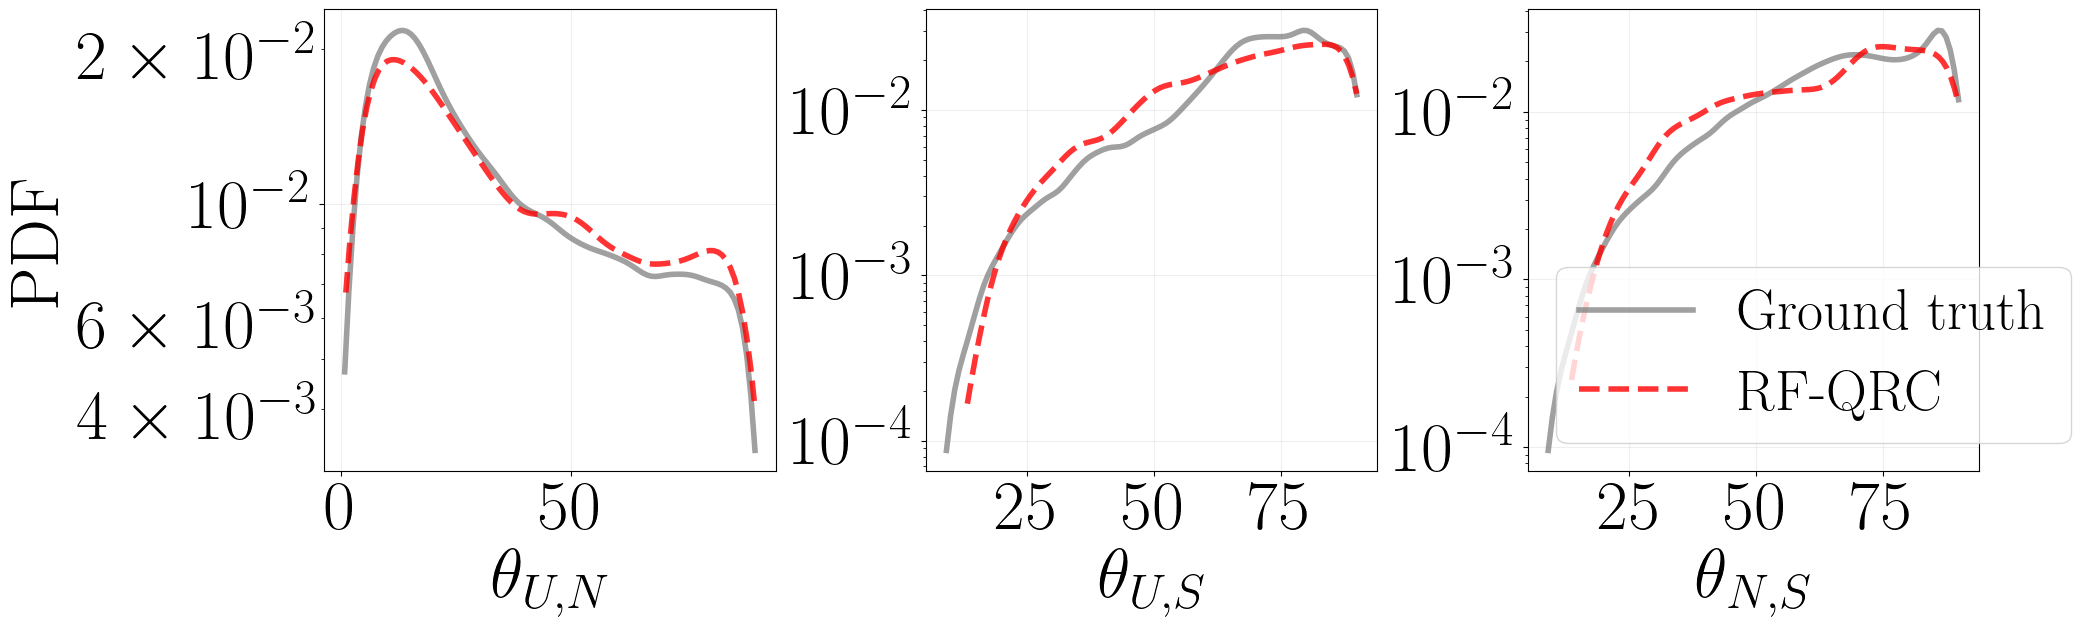

In [38]:
plt.rcParams["font.size"] = 50
plt.rcParams["figure.figsize"] = (22,6)


# Theta Unstable, Neutral - Unstable, Stable - Neutral, Stable
dist = 100
# for ens in range(qu_ensemble): 
for j in ens:
    lor_stat , lor_stat_pred = plot_lorenz63_CLV_stats_predq(thetas,angle_clv_qrc[j][transients:],dist)
    plt.legend(fontsize=41)
    # plt.savefig('CLV_stats.pdf', format='pdf', dpi=1200,bbox_inches="tight")  # Adjust pad_inches as needed

    plt.show()
    

CLV angle - visualization

Quantum Ensemble 3


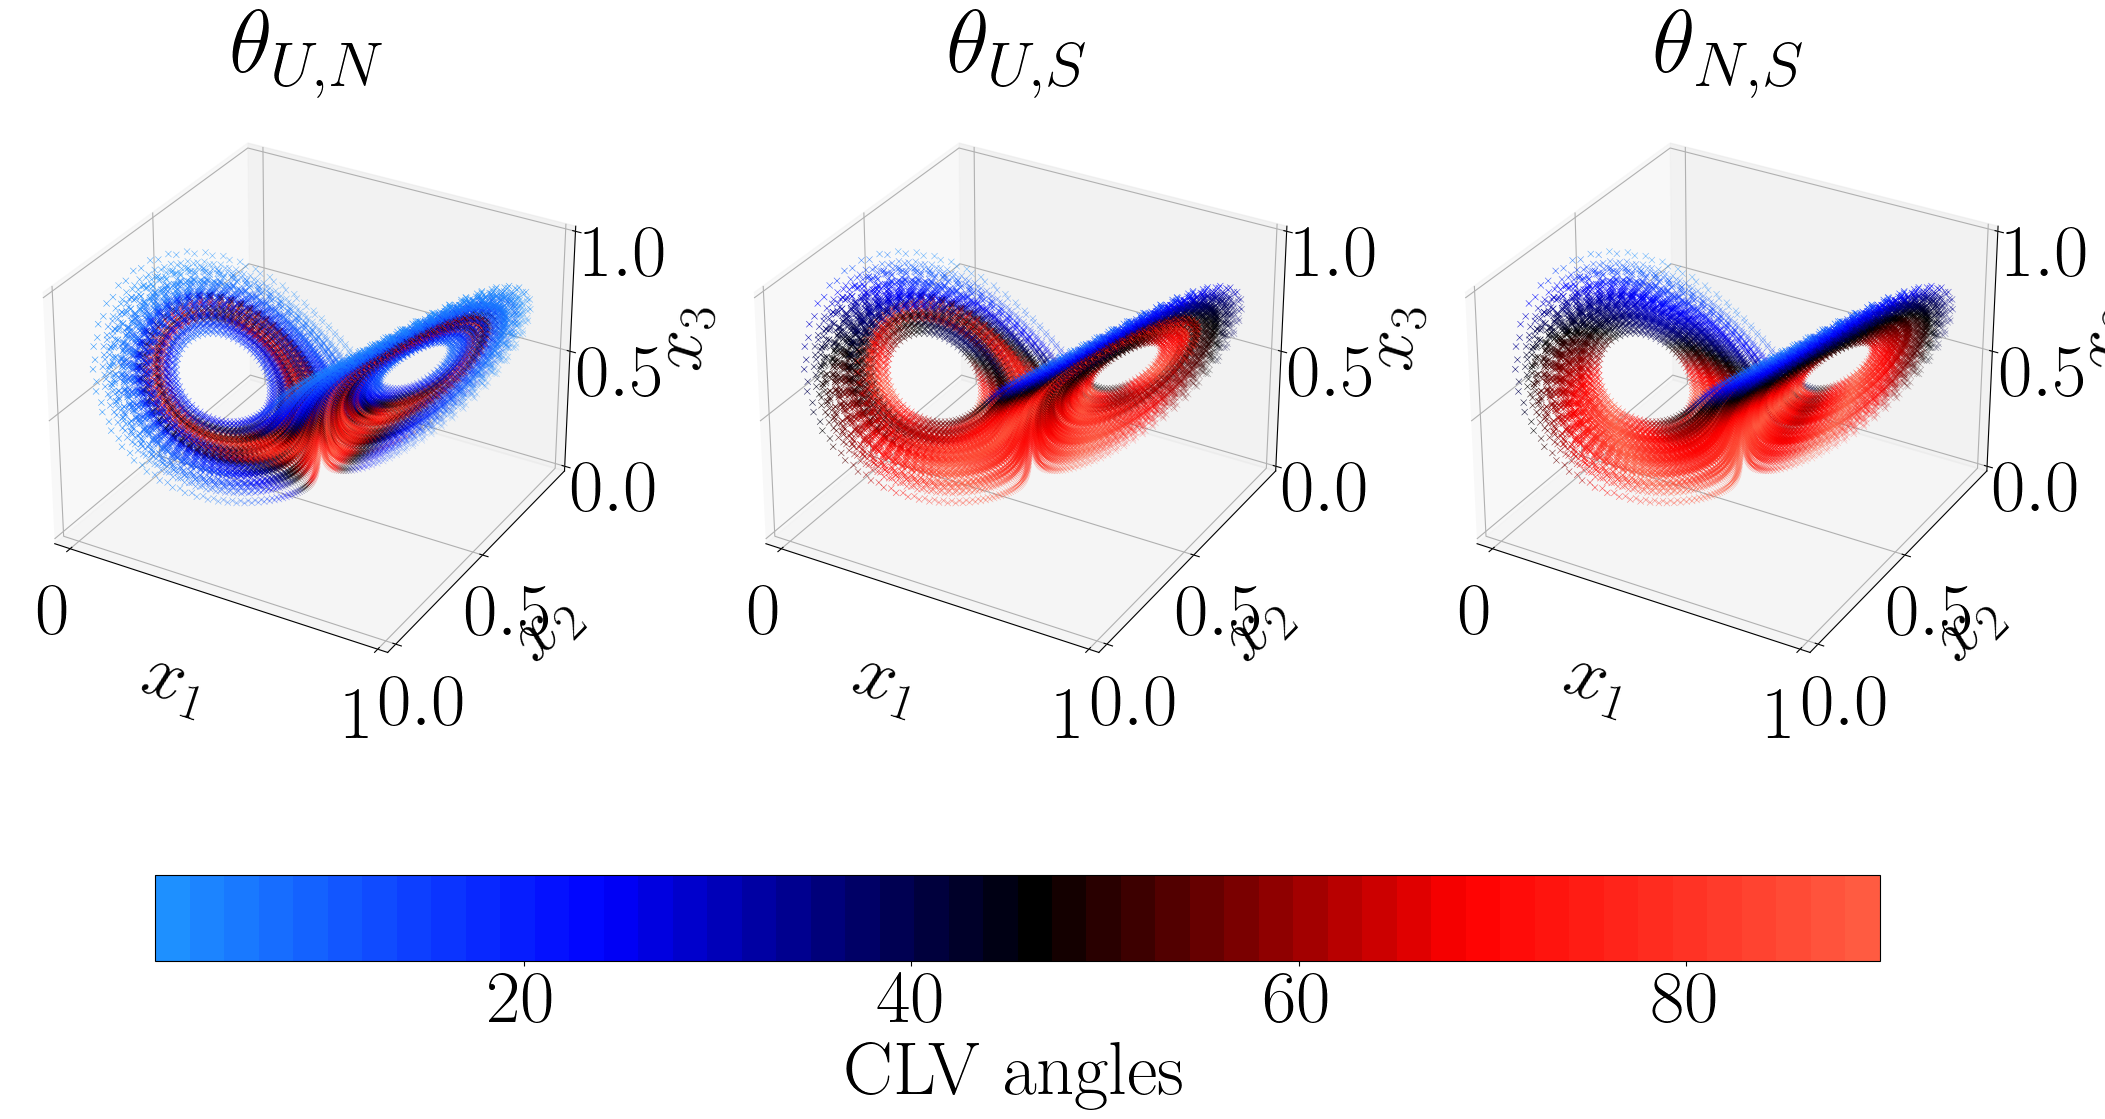

In [39]:



#Unstable
d_plot1 = 0 # which dimension CLVs to color the attractor from  
#Neutral
d_plot2 = 1 # which dimension CLVs to color the attractor from 
#Stable
d_plot3 = 2 # which dimension CLVs to color the attractor from 

custom_continuous_cmap = create_custom_colormap(map_name='name',type='continuous',N=50,colors=["dodgerblue","blue","black","red","tomato"])
# custom_discrete_cmap = create_custom_colormap(map_name='defne',type='discrete')
t = np.arange(0,10,0.01)
color_plot = custom_continuous_cmap
custom_continuous_cmap



plt.rcParams["font.size"] = 54
plt.rcParams["figure.figsize"] = (22,6)

transients = int(step_le/10)
len_plot = step_le-transients

# for ens in range(qu_ensemble):
for j in ens:
    print('Quantum Ensemble',j)
    # plot_lorenz63_attractor_clvs_subplot_scaled(Yh_t_qrc[j][transients:len_plot],int((Ntotal-Ntherm)/norm_time),angle_clv_qrc[j][transients:len_plot],color_plot)
    plot_lorenz63_attractor_clvs_subplot_scaled(Yh_t_qrc[j][transients:],len_plot,angle_clv_qrc[j][:len_plot],color_plot)
    # plt.savefig('CLV_angle_quantum.pdf', format='pdf', dpi=100,bbox_inches="tight", pad_inches=0.5)  # Adjust pad_inches as needed
  
    # plt.savefig('CLV_angle.pdf', format='pdf', dpi=800,bbox_inches="tight", pad_inches=0.5)  # Adjust pad_inches as needed
    plt.show()


